## **1. Load and import libraries**

In [ ]:
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree

## **2. Load and encode the dataset**

In [ ]:
def encode_df(df):
# Encode categorical features and target
# We map 'Yes'/'No' in a way that ensures 'Yes' (0) goes to the left child, 'No' (1) to the right
    df2 = df.copy()
    bin_map = {'Có': 0, 'Không': 1}
    df2['Chứng_chỉ_Ielts']   = df2['Chứng_chỉ_Ielts'].map(bin_map)
    df2['Cộng_Điểm_Dân_Tộc'] = df2['Cộng_Điểm_Dân_Tộc'].map(bin_map)
    df2['Đậu_ĐH']            = df2['Đậu_ĐH'].map({'Có': 1, 'Không': 0})
    return df2

# Load the dataset
df = pd.read_csv(
    'Student_Pass_Dataset.csv',
    names=['Điểm_Tốt_Nghiệp', 'Chứng_chỉ_Ielts', 'Cộng_Điểm_Dân_Tộc', 'Đậu_ĐH'],
    header=0
)
print("Original dataset:")
display(df)

# Encode
df_encoded = encode_df(df)
print("Encoded dataset:")
display(df_encoded)

Original dataset:


,Điểm_Tốt_Nghiệp,Chứng_chỉ_Ielts,Cộng_Điểm_Dân_Tộc,Đậu_ĐH
0,12.0,Không,Không,Không
1,14.5,Không,Có,Không
2,16.0,Không,Không,Không
3,18.0,Không,Có,Không
4,20.0,Có,Không,Có
5,22.0,Không,Không,Không
6,24.0,Có,Có,Có
7,26.0,Không,Không,Có


Encoded dataset:


,Điểm_Tốt_Nghiệp,Chứng_chỉ_Ielts,Cộng_Điểm_Dân_Tộc,Đậu_ĐH
0,12.0,1,1,0
1,14.5,1,0,0
2,16.0,1,1,0
3,18.0,1,0,0
4,20.0,0,1,1
5,22.0,1,1,0
6,24.0,0,0,1
7,26.0,1,1,1


## **3. Compute root entropy of the target**

In [ ]:
def gini (probs):
    return 1 - np.sum(np.square(probs))

root_probs = df_encoded['Đậu_ĐH'].value_counts(normalize=True).sort_index().values
root_gini  = gini(root_probs)
print(f"Root Gini impurity của Đậu_ĐH = {root_gini:.4f}")

Root Gini impurity của Đậu_ĐH = 0.4688


In [ ]:
# Lấy cột mục tiêu
target_col = df_encoded['Đậu_ĐH']
print("Bước 1 - target_col:")
print(target_col.head(), "\n")  # in 5 giá trị đầu

Bước 1 - target_col:
0    0
1    0
2    0
3    0
4    1
Name: Đậu_ĐH, dtype: int64 



In [ ]:
# Đếm số lượng từng lớp và chuẩn hóa thành tỉ lệ
value_counts_norm = target_col.value_counts(normalize=True)
print("Bước 2 - value_counts(normalize=True):")
print(value_counts_norm, "\n")

Bước 2 - value_counts(normalize=True):
Đậu_ĐH
0    0.625
1    0.375
Name: proportion, dtype: float64 



In [ ]:
# Sắp xếp theo giá trị nhãn tăng dần (0 trước 1)
sorted_counts = value_counts_norm.sort_index()
print("Bước 3 - sort_index():")
print(sorted_counts, "\n")


Bước 3 - sort_index():
Đậu_ĐH
0    0.625
1    0.375
Name: proportion, dtype: float64 



In [ ]:
# Chuyển sang mảng NumPy
root_probs = sorted_counts.values
print("Bước 4 - .values:")
print(root_probs, "\n")

Bước 4 - .values:
[0.625 0.375] 



In [ ]:
# Tính Gini từ root_probs
root_gini = 1 - np.sum(np.square(root_probs))
print(f"Bước 5 - Gini impurity tại gốc: {root_gini:.4f}")

Bước 5 - Gini impurity tại gốc: 0.4688


## **4. Compute Information Gain for each feature**

In [ ]:
print("\nGini Gain cho từng thuộc tính:")
features = ['Chứng_chỉ_Ielts','Điểm_Tốt_Nghiệp','Cộng_Điểm_Dân_Tộc']
for feat in features:
    print(f"\n- Thuộc tính: {feat}")
    vals = sorted(df_encoded[feat].unique())
    thresholds = [0.5] if feat in ['Chứng_chỉ_Ielts','Cộng_Điểm_Dân_Tộc'] \
                 else [(vals[i]+vals[i+1])/2 for i in range(len(vals)-1)]
    best_gain, best_thr = -1, None
    for thr in thresholds:
        left  = df_encoded[df_encoded[feat] <= thr]['Đậu_ĐH']
        right = df_encoded[df_encoded[feat] >  thr]['Đậu_ĐH']
        pL, pR = left.value_counts(normalize=True).values, right.value_counts(normalize=True).values
        gL, gR = gini(pL), gini(pR)
        wG     = (len(left)/len(df_encoded))*gL + (len(right)/len(df_encoded))*gR
        gain   = root_gini - wG
        print(f"    Ngưỡng ≤ {thr}: Gini(L)={gL:.4f}, Gini(R)={gR:.4f}, Gini trọng số={wG:.4f}, Gain={gain:.4f}")
        if gain > best_gain:
            best_gain, best_thr = gain, thr
    print(f"  → Chọn ngưỡng {best_thr} với Gini Gain = {best_gain:.4f}")


Gini Gain cho từng thuộc tính:

- Thuộc tính: Chứng_chỉ_Ielts
    Ngưỡng ≤ 0.5: Gini(L)=0.0000, Gini(R)=0.2778, Gini trọng số=0.2083, Gain=0.2604
  → Chọn ngưỡng 0.5 với Gini Gain = 0.2604

- Thuộc tính: Điểm_Tốt_Nghiệp
    Ngưỡng ≤ 13.25: Gini(L)=0.0000, Gini(R)=0.4898, Gini trọng số=0.4286, Gain=0.0402
    Ngưỡng ≤ 15.25: Gini(L)=0.0000, Gini(R)=0.5000, Gini trọng số=0.3750, Gain=0.0938
    Ngưỡng ≤ 17.0: Gini(L)=0.0000, Gini(R)=0.4800, Gini trọng số=0.3000, Gain=0.1688
    Ngưỡng ≤ 19.0: Gini(L)=0.0000, Gini(R)=0.3750, Gini trọng số=0.1875, Gain=0.2812
    Ngưỡng ≤ 21.0: Gini(L)=0.3200, Gini(R)=0.4444, Gini trọng số=0.3667, Gain=0.1021
    Ngưỡng ≤ 23.0: Gini(L)=0.2778, Gini(R)=0.0000, Gini trọng số=0.2083, Gain=0.2604
    Ngưỡng ≤ 25.0: Gini(L)=0.4082, Gini(R)=0.0000, Gini trọng số=0.3571, Gain=0.1116
  → Chọn ngưỡng 19.0 với Gini Gain = 0.2812

- Thuộc tính: Cộng_Điểm_Dân_Tộc
    Ngưỡng ≤ 0.5: Gini(L)=0.4444, Gini(R)=0.4800, Gini trọng số=0.4667, Gain=0.0021
  → Chọn ngưỡng 0.5 v

## **5. Train a full-depth tree and visualize**

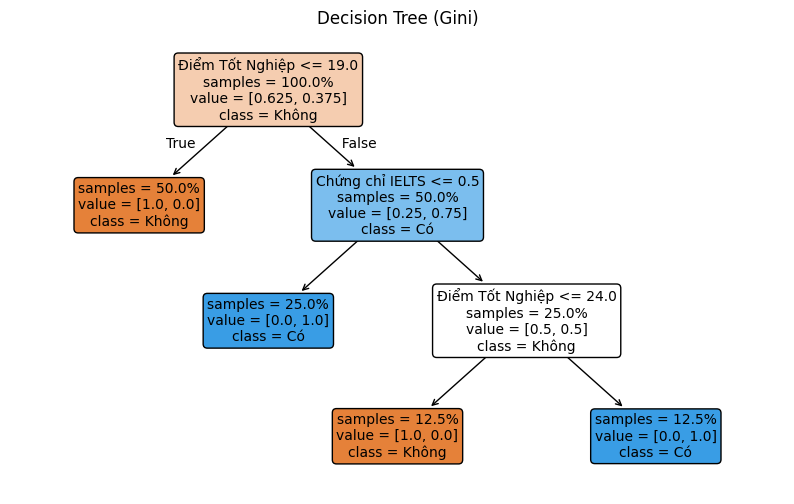

In [ ]:
# Train the full decision tree (criterion='gini') and visualize
X   = df_encoded[features]
y   = df_encoded['Đậu_ĐH']
clf = DecisionTreeClassifier(criterion='gini', random_state=0)
clf.fit(X, y)

plt.figure(figsize=(10,6))
plot_tree(
    clf,
    feature_names=['Chứng chỉ IELTS','Điểm Tốt Nghiệp','Cộng Điểm Dân Tộc'],
    class_names=['Không','Có'],
    filled=True, rounded=True, proportion=True, impurity=False, fontsize=10
)
plt.title('Decision Tree (Gini)')
plt.show()

##**6. Test**

In [ ]:
_mapping = {'Có': 0, 'Không': 1}
def encode_input(record):
    return [
        _mapping[record['Chứng_chỉ_Ielts']],
        record['Điểm_Tốt_Nghiệp'],
        _mapping[record['Cộng_Điểm_Dân_Tộc']]
    ]

def predict_pass(record):
    x_list = encode_input(record)
    df_new  = pd.DataFrame([x_list], columns=features)
    pred    = clf.predict(df_new)[0]
    return 'Có' if pred==1 else 'Không'

new_student = {
    'Điểm_Tốt_Nghiệp': 27.0,
    'Chứng_chỉ_Ielts': 'Có',
    'Cộng_Điểm_Dân_Tộc': 'Không'
}
print("Kết quả dự đoán:", predict_pass(new_student))

Kết quả dự đoán: Có


## **7. Demo with Gradio**

In [ ]:
def predict_and_plot(diem, ielts, dan_toc):
    try:
        record = {
            'Điểm_Tốt_Nghiệp': float(diem),
            'Chứng_chỉ_Ielts': ielts,
            'Cộng_Điểm_Dân_Tộc': dan_toc
        }

        result = predict_pass(record)

        fig, ax = plt.subplots(figsize=(8,6))
        plot_tree(
            clf,
            feature_names=['Chứng chỉ IELTS','Điểm Tốt Nghiệp','Cộng Điểm Dân Tộc'],
            class_names=['Không','Có'],
            filled=True, rounded=True, proportion=True, impurity=False,
            fontsize=8, ax=ax
        )
        ax.set_title('Decision Tree (Gini)')
        plt.tight_layout()

        return result, fig

    except Exception as e:
        return f"Lỗi nhập liệu: {e}", None

iface = gr.Interface(
    fn=predict_and_plot,
    inputs=[
        gr.Number(label="Điểm Tốt Nghiệp", value=None, placeholder="Ví dụ: 27.0"),
        gr.Radio(['Có','Không'], label="Chứng chỉ IELTS", value='Có'),
        gr.Radio(['Có','Không'], label="Cộng Điểm Dân Tộc", value='Không'),
    ],
    outputs=[
        gr.Textbox(label="Dự đoán Đậu Đại Học"),
        gr.Plot(label="Decision Tree")
    ],
    title="Demo Student Pass Predictor (Gini)",
    description="""
    **Hướng dẫn nhập liệu**
    - **Điểm Tốt Nghiệp**: Nhập số điểm tốt nghiệp (float).
    - **Chứng chỉ IELTS**: Chọn `Có`/`Không`.
    - **Cộng Điểm Dân Tộc**: Chọn `Có`/`Không`.
    Bấm **Run** để xem kết quả dự đoán và cây quyết định dùng Gini impurity.
    """
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ab7fac3ae410eed6e4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
